ノイズの大きさと信号の弱さがfMRIの解像度を決める。本格的な分析の前に、ノイズを可能な除去する必要がある。ここでは、fMRIのデータを前処理する方法を学ぶ。

fmriprepというパイプラインを使って、以下の前処理を紹介する。
 - Image transformations（画像変換）
 - Head motion correction（頭部の動きの補正）
 - Spatial Normalization（空間正規化）
 - Spatial Smoothing（空間スムージング）

![preprocessing](../images/preprocessing/preprocessing.png)

distortion correctionやslice timing correctionは、一部の研究では必要な処理ではあるが、ここでは省略する。

# Image transformations（画像変換）

目的：ボクセル強度を表す3次元または4次元の行列を、アフィン変換を用いて2次元に変換する。

直感的に理解するために、ipywidgetsを使ってインタラクティブなプロットで見てみる。
- 剛体変換を適用した3D立方体
  - 剛体変換：任意の二点間の距離を保つ変換。平行移動(x,y,z)と回転(rot_x, rot_y, rot_z)のみ。
  - アフィン変換：剛体変換にスケーリングとシアリングを加えた変換。
    - スケーリング：拡大縮小
    - シアリング：物体を一方向にずらす操作で、物体の形状を歪める
- 立方体はエイリアシングで歪む
  - エイリアシング：ギザギザな階段状になること
  - アフィン変換を適用した後の画像は、完全な復元はできておらず、補間する必要がある
  - 再スライシング、補間、空間平滑化で対処する

In [1]:
# 直感的な理解

%matplotlib inline

from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from nibabel.affines import apply_affine, from_matvec, to_matvec
from scipy.ndimage import affine_transform, map_coordinates
import nibabel as nib
from ipywidgets import interact, FloatSlider

def plot_rigid_body_transformation(trans_x=0, trans_y=0, trans_z=0, rot_x=0, rot_y=0, rot_z=0):
    '''This plot creates an interactive demo to illustrate the parameters of a rigid body transformation'''
    fov = 30
    radius = 10
    x, y, z = np.indices((fov, fov, fov))
    cube = ((x > fov//2 - radius//2) & (x < fov//2 + radius//2)) & ((y > fov//2 - radius//2) & (y < fov//2 + radius//2)) & ((z > fov//2 - radius//2) & (z < fov//2 + radius//2 ))
    cube = cube.astype(int)

    vec = np.array([trans_x, trans_y, trans_z])
    
    rot_x = np.radians(rot_x)
    rot_y = np.radians(rot_y)
    rot_z = np.radians(rot_z)
    rot_axis1 = np.array([[1, 0, 0],
                         [0, np.cos(rot_x), -np.sin(rot_x)],
                         [0, np.sin(rot_x), np.cos(rot_x)]])

    rot_axis2 = np.array([[np.cos(rot_y), 0, np.sin(rot_y)],
                         [0, 1, 0],
                         [-np.sin(rot_y), 0, np.cos(rot_y)]])

    rot_axis3 = np.array([[np.cos(rot_z), -np.sin(rot_z), 0],
                         [np.sin(rot_z), np.cos(rot_z), 0],
                         [0, 0, 1]])

    rotation = rot_axis1 @ rot_axis2 @ rot_axis3
    
    affine = from_matvec(rotation, vec)
    
    i_coords, j_coords, k_coords = np.meshgrid(range(cube.shape[0]), range(cube.shape[1]), range(cube.shape[2]), indexing='ij')
    coordinate_grid = np.array([i_coords, j_coords, k_coords])
    coords_last = coordinate_grid.transpose(1, 2, 3, 0)
    transformed = apply_affine(affine, coords_last)
    coords_first = transformed.transpose(3, 0, 1, 2)

    fig = plt.figure(figsize=(15, 12))
    ax = plt.axes(projection='3d')
    ax.voxels(map_coordinates(cube, coords_first))
    ax.set_xlabel('x', fontsize=16)
    ax.set_ylabel('y', fontsize=16)
    ax.set_zlabel('z', fontsize=16)

interact(plot_rigid_body_transformation, 
         trans_x=FloatSlider(value=0, min=-10, max=10, step=1),
         trans_y=FloatSlider(value=0, min=-10, max=10, step=1),
         trans_z=FloatSlider(value=0, min=-10, max=10, step=1),
         rot_x=FloatSlider(value=0, min=0, max=360, step=15),
         rot_y=FloatSlider(value=0, min=0, max=360, step=15),
         rot_z=FloatSlider(value=0, min=0, max=360, step=15))

interactive(children=(FloatSlider(value=0.0, description='trans_x', max=10.0, min=-10.0, step=1.0), FloatSlide…

<function __main__.plot_rigid_body_transformation(trans_x=0, trans_y=0, trans_z=0, rot_x=0, rot_y=0, rot_z=0)>

数学的な解説

- 設定：ボクセル空間座標(i,j,k)を、ターゲット空間座標(x,y,z)に変換する。
  - f : 変換するアフィン線形変換関数として、
    - $(x, y, z) = f(i, j, k)$
- アフィン変換のポイント：スケーリング、回転、平行移動

**スケーリング**

第1次元を$p$、第2次元を$q$、第3次元を$r$倍拡大すると考えると、

$$
\begin{bmatrix}
x\\
y\\
z
\end{bmatrix} 
\quad
=
\quad
\begin{bmatrix}
pi\\
qj\\
rk
\end{bmatrix}
\quad
=
\quad
\begin{bmatrix}
p & 0 & 0 \\
0 & q & 0 \\
0 & 0 & r
\end{bmatrix}
\quad
\begin{bmatrix}
i\\
j\\
k
\end{bmatrix}
$$


**回転**

どの次元を回転させるかで、回転行列は変化する。

第1次元を$\gamma$、第2次元を$\phi$、第3次元を$\theta$回転すると考えると、

$$
\begin{bmatrix}
x\\
y\\
z
\end{bmatrix}
\quad
=
\quad
\begin{bmatrix}
1 & 0 & 0 \\
0 & \cos(\gamma) & -\sin(\gamma) \\
0 & \sin(\gamma) & \cos(\gamma) \\
\end{bmatrix}
\quad
\begin{bmatrix}
i \\
j \\
k
\end{bmatrix}
$$

$$
\begin{bmatrix}
x \\
y \\
z \\
\end{bmatrix}
\quad
=
\quad
\begin{bmatrix}
\cos(\phi) & 0 & \sin(\phi) \\
0 & 1 & 0 \\
-\sin(\phi) & 0 & \cos(\phi) \\
\end{bmatrix}
\quad
\begin{bmatrix}
i \\
j \\
k 
\end{bmatrix}
$$

$$
\begin{bmatrix}
x \\
y \\
z
\end{bmatrix}
\quad
=
\quad
\begin{bmatrix}
\cos(\theta) &  -\sin(\theta) & 0 \\
\sin(\theta) & \cos(\theta) & 0 \\
0 & 0 & 1 \\
\end{bmatrix}
\quad
\begin{bmatrix}
i \\
j \\
k
\end{bmatrix}
$$

**スケーリングと回転**

どの次元を回転させるかで、回転行列は変化する。

第1次元を$p$、第2次元を$q$、第3次元を$r$倍拡大させて、第2次元を$\phi$、第3次元を$\gamma$回転させると、

$$
\begin{bmatrix}
x \\
y \\
z
\end{bmatrix}
\quad
=
\quad
\begin{bmatrix}
\cos(\phi) & 0 & \sin(\phi) \\
0 & 1 & 0 \\
-\sin(\phi) & 0 & \cos(\phi) \\
\end{bmatrix}
\quad
\begin{bmatrix}
\cos(\theta) &  -\sin(\theta) & 0 \\
\sin(\theta) & \cos(\theta) & 0 \\
0 & 0 & 1 \\
\end{bmatrix}
\quad
\begin{bmatrix}
p & 0 & 0 \\
0 & q & 0 \\
0 & 0 & r \\
\end{bmatrix}
\quad
\begin{bmatrix}
i\\
j\\
k\\
\end{bmatrix}
$$

変換行列の部分をMと置くと、

$$
M
\quad
=
\quad
\begin{bmatrix}
\cos(\phi) & 0 & \sin(\phi) \\
0 & 1 & 0 \\
-\sin(\phi) & 0 & \cos(\phi) \\
\end{bmatrix}
\quad
\begin{bmatrix}
\cos(\theta) &  -\sin(\theta) & 0 \\
\sin(\theta) & \cos(\theta) & 0 \\
0 & 0 & 1 \\
\end{bmatrix}
\quad
\begin{bmatrix}
p & 0 & 0 \\
0 & q & 0 \\
0 & 0 & r \\
\end{bmatrix}
$$

$$
\begin{bmatrix}
x \\
y \\
z 
\end{bmatrix}
\quad
=
\quad
M
\quad
\begin{bmatrix}
i \\
j \\
k
\end{bmatrix}
$$

**スケーリングと回転と平行移動**

平行移動は、その座標差分を表すベクトルを足すことで表現できる。

第1次元を$p$、第2次元を$q$、第3次元を$r$倍拡大させて、第2次元を$\phi$、第3次元を$\gamma$回転、第1次元を$a$、第2次元を$b$、第3次元を$c$だけ平行移動させると、

$$
\begin{bmatrix}
x \\
y \\
z
\end{bmatrix}
\quad
=
\quad
M
\quad
\begin{bmatrix}
i \\
j \\
k
\end{bmatrix}
\quad
+
\quad
\begin{bmatrix}
a \\
b \\
c
\end{bmatrix}
$$

**スケーリングと回転と平行移動をシンプルに表現する方法**

3次元アフィン変換は、4次元変換行列との単純な内積で表現できる。

以下の変換をしたあとで、$(x, y, z)$のみを抜き出せば良い。


$$
\begin{bmatrix}
x \\
y \\
z \\
1
\end{bmatrix}
\quad
=
\quad
\begin{bmatrix}
m_{1,1} & m_{1,2} & m_{1,3} & a \\
m_{2,1} & m_{2,2} & m_{2,3} & b \\
m_{3,1} & m_{3,2} & m_{3,3} & c \\
0 & 0 & 0 & 1 \\
\end{bmatrix}
\quad
\begin{bmatrix}
i \\
j \\
k \\
1
\end{bmatrix}
$$

画像アフィン変換は、磁石のイソセンタを基準にボクセル座標からmm座標に変換するための一連の変換の組み合わせと考えることができる(?)

<img src="https://nipy.org/nibabel/_images/illustrating_affine.png" />

# 損失関数

どのようにアフィン変換をすれば良いのか？を決めるために、損失関数を定義する。

損失関数は、ケースバイケースで使い分ける。

| コスト関数 | 用途 | 例 |
|:---:|:---:|:---:|
| 二乗誤差和 | 同じモダリティとスケーリングの画像 | 2つのT2*画像 |
| 正規化相互相関 | 同じモダリティの画像 | 2つのT1画像 |
| 相関比 | 任意のモダリティ | T1とFLAIR |
| 相互情報量または正規化相互情報量 | 任意のモダリティ | T1とCT |
| 境界ベースの登録 | 注目の境界を横断するいくつかの対比のある画像 | EPIとT1 |

例えば以下のインタラクティブな例では、変換画像と正解画像の差の2乗和をとる。

In [2]:
def plot_affine_cost(trans_x=0, trans_y=0):
    from copy import deepcopy 
    '''This function creates an interactive demo to highlight how a cost function works in image registration.'''
    fov = 30
    radius = 15
    x, y = np.indices((fov, fov))
    square1 = (x < radius-2) & (y < radius-2)
    square2 = ((x > fov//2 - radius//2) & (x < fov//2 + radius//2)) & ((y > fov//2 - radius//2) & (y < fov//2 + radius//2))
    square1 = square1.astype(float)
    square2 = square2.astype(float)

    vec = np.array([trans_y, trans_x])
    
    affine = from_matvec(np.eye(2), vec)
    
    i_coords, j_coords = np.meshgrid(range(square1.shape[0]), range(square1.shape[1]), indexing='ij')
    coordinate_grid = np.array([i_coords, j_coords])
    coords_last = coordinate_grid.transpose(1, 2, 0)
    transformed = apply_affine(affine, coords_last)
    coords_first = transformed.transpose(2, 0, 1)
    
    transformed_square = map_coordinates(square1, coords_first)
    f,a = plt.subplots(ncols=3, figsize=(15, 5))
    a[0].imshow(transformed_square)
    a[0].set_xlabel('x', fontsize=16)
    a[0].set_ylabel('y', fontsize=16)
    a[0].set_title('Target Image', fontsize=18)
    
    a[1].imshow(square2)
    a[1].set_xlabel('x', fontsize=16)
    a[1].set_ylabel('y', fontsize=16)
    a[1].set_title('Reference Image', fontsize=18)
    
    point_x = deepcopy(trans_x)
    point_y = deepcopy(trans_y)
    sse = np.sum((transformed_square - square2)**2)
    a[2].bar(0, sse)
    a[2].set_ylim([0, 350])
    a[2].set_ylabel('SSE', fontsize=18)
    a[2].set_xlabel('Cost Function', fontsize=18)
    a[2].set_xticks([])
    a[2].set_title(f'Parameters: ({int(trans_x)},{int(trans_y)})', fontsize=20)
    plt.tight_layout()
    
interact(plot_affine_cost, 
         trans_x=FloatSlider(value=0, min=-30, max=0, step=1),
         trans_y=FloatSlider(value=0, min=-30, max=0, step=1))

interactive(children=(FloatSlider(value=0.0, description='trans_x', max=0.0, min=-30.0, step=1.0), FloatSlider…

<function __main__.plot_affine_cost(trans_x=0, trans_y=0)>

# Realignmnt(再調整)

剛体変換を利用して、頭部の動きを補正する前処理をする。つまり、再調整によって各ボリュームをほぼ同じ位置に置くことを考える（2つ以上の異なる時間点で撮影された画像データを一致させるための手法を特に、image registrationと呼ぶ）。

正解ボリュームの候補は、最初のボリューム、中間のボリューム、最後のボリュームの平均などがある。

一方で、頭部の動きは常に磁場を歪ませ、この手順では対処できない信号強度の非線形変化をもたらす可能性あり。特に機能的結合に基づく解析が多いresting-stateの文献では、頭部の動きが偽の相関を引き起こす可能性がある。

一定量以上動いた被験者を除外すること、*scrubbing*によるボリュームの除去、第1レベルの一般線形モデルでボリュームをダミーコードでモデル化したりして、データにおけるこれらの時点の影響を除去を試みる。

/Users/hidekiizumi/miniforge3/lib/python3.9/site-packages/bids/layout/validation.py:153: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Text(0.5, 1.0, 'Rotation')

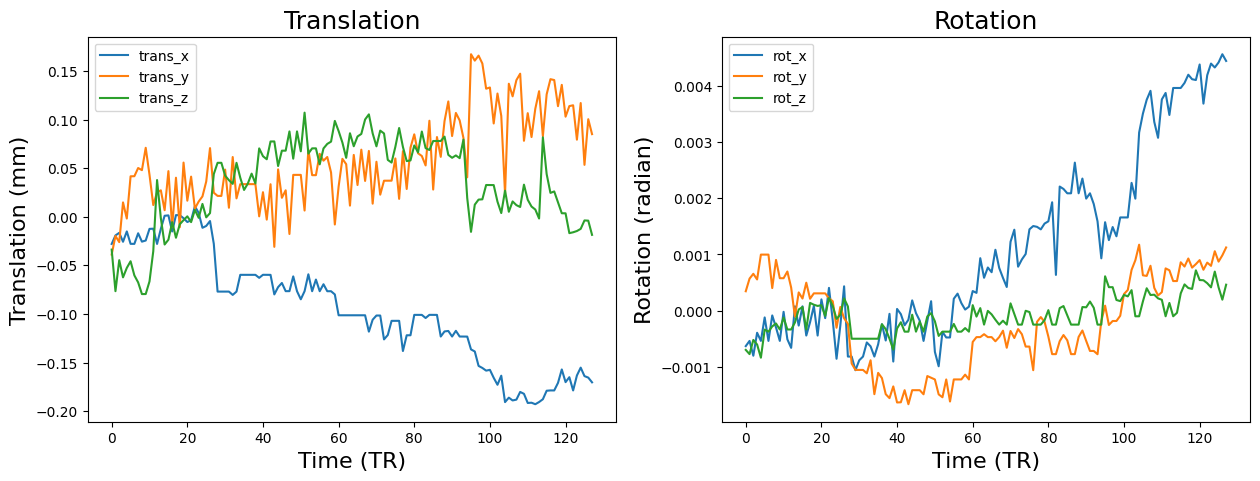

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bids import BIDSLayout, BIDSValidator
import os

data_dir = '/Users/hidekiizumi/myproject/Localizer'
layout = BIDSLayout(data_dir, derivatives=True)

data = pd.read_csv(layout.get(subject='S01', scope='derivatives', extension='.tsv')[0].path, sep='\t')

f,a = plt.subplots(ncols=2, figsize=(15,5))

data.loc[:,['trans_x','trans_y','trans_z']].plot(ax=a[0])
a[0].set_ylabel('Translation (mm)', fontsize=16)
a[0].set_xlabel('Time (TR)', fontsize=16)
a[0].set_title('Translation', fontsize=18)

data.loc[:,['rot_x','rot_y','rot_z']].plot(ax=a[1])
a[1].set_ylabel('Rotation (radian)', fontsize=16)
a[1].set_xlabel('Time (TR)', fontsize=16)
a[1].set_title('Rotation', fontsize=18)

# 空間正規化

被験者間の脳の形状の違いを無くすことも、重要なimage registrationの一つである。

空間正規化は、各被験者の脳データを共通の定位空間(stereotactic space)にワープさせるものである。アルゴリズムは様々であるが、12パラメータの線形アフィン変換よりも、複雑な非線形正規化が使われるようになってきている。

ここでは、fmriprepに実装されている*diffeomorphic registration*を用いて、被験者空間を定位空間に変換し、被験者空間に戻すことで、被験者間の脳の形状の違いを無くすことを試みる。

まず、頭蓋骨とその周囲の硬膜から脳を抽出する。赤い輪郭を調べることで、アルゴリズムがどの程度うまくいったかを確認する。

![normalization](../images/preprocessing/T1_normalization.png)

次に、解剖学的画像を異なる組織タイプに分割する。

![normalization](../images/preprocessing/T1_segmentation.png)

### 解剖学的T1wリファレンス(T1 weighted)の空間的正規化

fMRIのものを、解剖学的に正確なT1と関連付けて空間正規化を行いたい（おそらく）。

fmriprepは[ANTs](http://stnava.github.io/ANTs/)を使って、非線形空間正規化を行う。以下は、T1wリファレンスを定位リファレンス空間にアライメントした結果。
![正規化](../images/preprocessing/sub-S01_space-MNI152NLin2009cAsym_T1w.svg)

### 機能的・解剖学的MRIデータのアライメント

次に、fMRIのデータの位置の質を、解剖学的なT1wを用いて評価する。EPI 空間から T1w 空間への変換には FSL `flirt` を使用し、BBR には FSL `fast` （脳組織分割）で算出した白質マスクを使用した。これらの画像は、T1画像と比較して、よりぼやけ、歪みがあることに注意。

![epi](../images/preprocessing/sub-S01_task-localizer_desc-flirtbbr_bold.svg)


# 空間スムージング

前処理パイプラインの最後のステップ。画像にフィルタを適用し、高周波の空間情報を除去する。3次元ガウスカーネルで畳み込む。平滑化の度合いは、FWHM（Full Width at Half Maximum）パラメータで分布の幅（つまり標準偏差）で指定する。

データ取得の段階で解像度を上げようと頑張ったのに、空間平滑化で画像の解像度を下げる理由：パーシャルボリューム効果、正規化後の残存解剖学的差異、空間変換の適用によるその他のエイリアシングの影響を軽減し、S/N比を向上させるため。

3Dガウシアンカーネルは、以下のようなものです。

# fmriprep

[fmriprep](https://fmriprep.readthedocs.io/en/stable/)を使えば、以下のことを簡単に行うことができる：

- fMRIデータを生データから完全に前処理された形にする。
- 異なるソフトウェアパッケージのツールを導入する。
- 利用可能な最高のツールを使用することで、最適なデータ処理品質を達成する。
- 前処理品質レポートを作成し、異常値を容易に特定することができる。
- 各サブジェクトの前処理段階に関する詳細な出力（意味のあるエラーを含む）。
- 処理ステップの自動化および並列化により、一般的な直線的な手動処理から大幅にスピードアップ。
- カスタマイズ性は低い
- 詳細な情報およびドキュメントは、https://fmriprep.readthedocs.io/。


In [5]:
from IPython.display import HTML

#HTML('/Users/hidekiizumi/myproject/Localizer/derivatives/fmriprep/sub-S01.html')
'/Users/hidekiizumi/myproject/Localizer/derivatives/fmriprep/sub-S01.html'

'/Users/hidekiizumi/myproject/Localizer/derivatives/fmriprep/sub-S01.html'

## Exercises

### Exercise 1. Inspect HTML output of other participants.
For this exercise, you will need to navigate to the derivatives folder containing the fmriprep preprocessed data `../data/data/localizer/derivatives/fmriprep` and inspect the html output of other subjects (ie., not 'S01'). Did the preprocessing steps works? are there any issues with the data that we should be concerned about?

In [6]:
'/Users/hidekiizumi/myproject/Localizer/derivatives/fmriprep/sub-S02.html'

'/Users/hidekiizumi/myproject/Localizer/derivatives/fmriprep/sub-S02.html'

A. 今回みた前処理の項目については問題ないかと思います。頭部の動きも補正できてるのがわかります。

ただ、「Correlations among nuisance regressors」を見ると、一部相関が見られます。これは、ヘッドモーションのみならず、生理学的なノイズ（例えば心拍数や呼吸パターンの影響）や不要な信号がfMRIデータと相関していないかをチェックするもので、相関があると、刺激があったからなのか、例えばその時ちょっと息苦しかったからなのか、変数の影響を切り分けることが困難になります。なので、もう少し詳しく調査する必要があります。